In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


# Importing Required Modules 

In [2]:
import pandas as pd
import cv2 as cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Model Hyper parameters

In [3]:
train_path = "/kaggle/input/extracting-attributes-from-fashion-images-2/train"
BATCH_SIZE = 64
EPOCHS = 20
INPUT_SHAPE = 244

# Data Importing

In [4]:
# training data
train_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv")
train_df

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0
...,...,...
18386,Image_train_18387.jpg,1
18387,Image_train_18388.jpg,2
18388,Image_train_18389.jpg,1
18389,Image_train_18390.jpg,1


In [5]:
# testing data
test_df = pd.read_csv("/kaggle/input/extracting-attributes-from-fashion-images-2/sample_submission.csv")
test_df

,file_name,label
0,Image_test_00001.jpg,0
1,Image_test_00002.jpg,0
2,Image_test_00003.jpg,0
3,Image_test_00004.jpg,0
4,Image_test_00005.jpg,0
...,...,...
5746,Image_test_05747.jpg,0
5747,Image_test_05748.jpg,0
5748,Image_test_05749.jpg,0
5749,Image_test_05750.jpg,0


## Checking for Imbalance in the dataset

In [6]:
train_df.label.value_counts()

1    5384
2    4084
3    2008
4    1972
6    1925
5    1616
0    1402
Name: label, dtype: int64

In [7]:
test_df.label.value_counts()

0    5751
Name: label, dtype: int64

In [8]:
train_df.label.unique()

array([0, 1, 2, 3, 5, 4, 6])

In [9]:
# Creating class weights for imbalance dataset
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df.label.to_numpy()),
                                                 y=train_df.label.to_numpy()))
class_weights

[1.8739555736702669,
 0.4879802589683719,
 0.6433118791101161,
 1.3084092202618098,
 1.3322949869603014,
 1.6257956152758133,
 1.3648237476808904]

In [10]:
weights = {x:y for x,y in enumerate(class_weights)}
weights

{0: 1.8739555736702669,
 1: 0.4879802589683719,
 2: 0.6433118791101161,
 3: 1.3084092202618098,
 4: 1.3322949869603014,
 5: 1.6257956152758133,
 6: 1.3648237476808904}

# Visualization the dataset

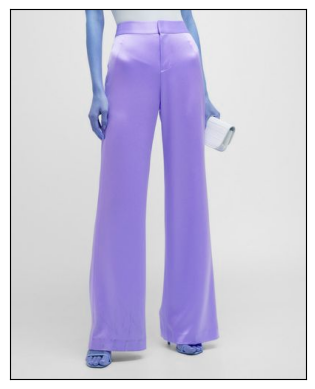

In [11]:
from matplotlib import pyplot as plt

train_files = os.listdir(train_path)
img = cv.imread(train_path+"/"+train_files[1])
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

# Creating Data Pipelines

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df['label'] = train_df['label'].astype(str)

datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode = "nearest",
)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/extracting-attributes-from-fashion-images-2/train",
    x_col="file_name",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(INPUT_SHAPE,INPUT_SHAPE))


Found 18391 validated image filenames belonging to 7 classes.


In [13]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_df['label'] = test_df['label'].astype(str)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/kaggle/input/extracting-attributes-from-fashion-images-2/test",
x_col="file_name",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(INPUT_SHAPE,INPUT_SHAPE))


Found 5751 validated image filenames belonging to 1 classes.


# Creating the Deep learning model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.python.keras import regularizers

# Pre Trained Models 

conv_base = VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(INPUT_SHAPE,INPUT_SHAPE,3)) # 244


# conv_base = tf.keras.applications.mobilenet.MobileNet( include_top=False,
#                                                            input_shape=(INPUT_SHAPE, INPUT_SHAPE,3),
#                                                            weights='imagenet')    

model = Sequential()

model.add(conv_base)
conv_base.trainable = False

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())


model.add(Dense(7, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(lr=0.00001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 21,140,295
Trainable params: 6,425,095
Non-trainable params: 14,715,200
____________________________________

# Training

In [17]:
# Setting up model callbacks
! mkdir /kaggle/working/model/

checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/model/CNN.h5", 
                                              monitor='val_accuracy', 
                                              verbose=0, 
                                              save_best_only=True,
                                              save_weights_only=False, 
                                              mode='auto', 
                                              save_freq='epoch', 
                                              options=None)

Epoch 1/20
287/287 [==============================] - 427s 1s/step - loss: 2.3422 - accuracy: 0.5029 - val_loss: 5.3612 - val_accuracy: 0.0232
Epoch 2/20
287/287 [==============================] - 341s 1s/step - loss: 1.5326 - accuracy: 0.5402 - val_loss: 5.2192 - val_accuracy: 0.0233
Epoch 3/20
287/287 [==============================] - 342s 1s/step - loss: 1.4653 - accuracy: 0.5361 - val_loss: 3.0889 - val_accuracy: 0.1900
Epoch 4/20
287/287 [==============================] - 351s 1s/step - loss: 1.4334 - accuracy: 0.5446 - val_loss: 7.7241 - val_accuracy: 5.2669e-04
Epoch 5/20
287/287 [==============================] - 341s 1s/step - loss: 1.4215 - accuracy: 0.5407 - val_loss: 3.9512 - val_accuracy: 0.1259
Epoch 6/20
287/287 [==============================] - 357s 1s/step - loss: 1.4157 - accuracy: 0.5392 - val_loss: 1.0113 - val_accuracy: 0.6803
Epoch 7/20
287/287 [==============================] - 347s 1s/step - loss: 1.3872 - accuracy: 0.5459 - val_loss: 12.1099 - val_accuracy: 0

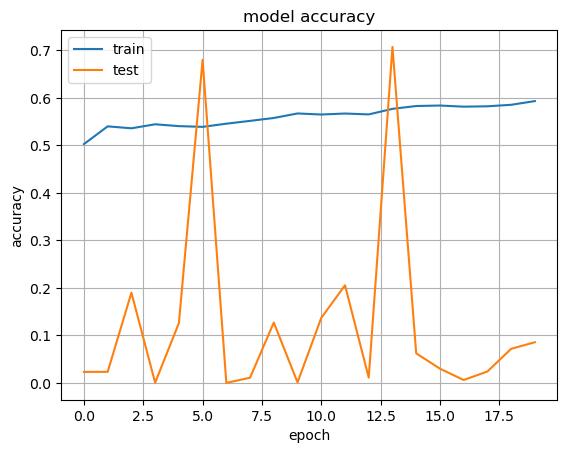

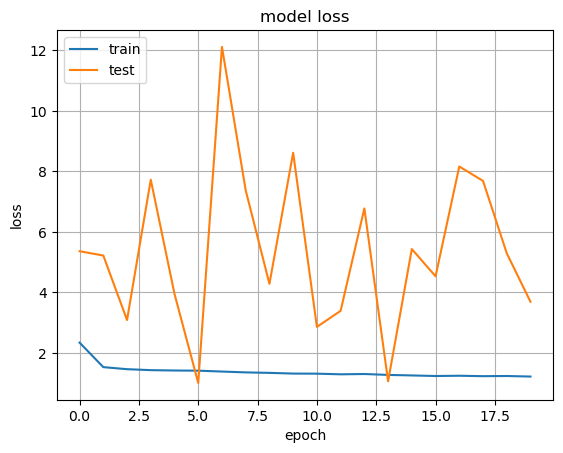

In [18]:
# Training the model

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=EPOCHS,
                    callbacks=[checkpoint])
#                     class_weight=weights)


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# Testing

In [19]:
# importing the best model

model = tf.keras.models.load_model("/kaggle/working/model/CNN.h5")

In [20]:
# Test accuracy
test_generator.reset()
model.evaluate(test_generator,
steps=STEP_SIZE_TEST)

89/89 [==============================] - 28s 308ms/step - loss: 1.0654 - accuracy: 0.7075


[1.0653965473175049, 0.7075140476226807]

In [21]:
test_generator.reset()
pred=model.predict(test_generator)

90/90 [==============================] - 32s 349ms/step


In [22]:
from sklearn.metrics import confusion_matrix
y_pred=np.argmax(pred,axis=1)

test_df['label'] = test_df['label'].astype(int)

cm=confusion_matrix(test_df.label, y_pred)
print(cm)

[[4072  845    7  111  326  390]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]]


# Creating submission.csv

In [23]:
filenames=test_generator.filenames

results=pd.DataFrame({"file_name":filenames,
                      "label":y_pred})
results.to_csv("submission.csv",index=False)

# Reasons for low testing accuracy 
**Problem**: Although the training and testing data belong to the same dataset, the split in the dataset is very different, training data has about 1402 belonging to class 0 and the testing data has all the data belonging to class 0. Inorder to make a model that generalizes well on the dataset we need at least a minimum of 5000 samples per class.So creating a good model with just 1402 images is a difficult task.

**Solution 1**: Adding more data in the dataset would lead to better learning of the model and would remove any bias in the dataset. But this is not possible in our case.

**Solution 2**: If adding data is not an option then using a pre-trained model could lead to better generalization. This is because pre trained models are trained for good feature extraction. This should work for our use case but from what I have learned while training the model, Due to the low amount of class 0 data in the dataset the pretrained model is also not able to learn well even though it generalizes well.

